## Support Vector Machines for prediction

Let's try using Support Vector machines algorithm for prediction.

### Feature selection pipeline

In [1]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MaxAbsScaler,FunctionTransformer, Imputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_extraction.text import HashingVectorizer

# First we build two utility functions to parse numeric and text data, 
# and wrap them using FunctionTransformer, so that they can be integrated into a sklearn pipeline:
def text_columns(X_train):
    return X_train.TEXT_FEATURES

def numeric_columns(X_train):
    numeric = ['APPLICANT_PRIOR_CLEARANCE_TO_DATE','DEVICENAME_PRIOR_CLEARANCE_TO_DATE']
    temp = X_train[numeric]
    return temp

get_numeric_data = FunctionTransformer(func = numeric_columns, validate=False) 
get_text_data = FunctionTransformer(func = text_columns,validate=False) 
# Note how we avoid putting any arguments into text_columns and numeric_columns

# We also need to create our regex token pattern to use in HashingVectorizer. 
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'   
#Note this regex will match either a whitespace or a punctuation to tokenize the string vector on these preferences  

# We also need to redefine the default feature selection function for regression to properly place into our pipeline:
def f_regression(X,Y):
    import sklearn
    return sklearn.feature_selection.f_regression(X,Y,center = False) # default is center = True


pipeline510k_SVM1 = Pipeline([
    
    ("union",FeatureUnion( # Note that FeatureUnion() accepts list of tuples, the first half of each tuple is the name of the transformer
        
        transformer_list = [
            
            ("numeric_subpipeline", Pipeline([ # Note we have subpipeline branches inside the main pipeline
                
                ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                ("imputer",Imputer()), # Step2: impute missing values (we don't expect any)
            
            ])), # Branching point of the FeatureUnion
            
            ("text_subpipeline",Pipeline([
            
                ("parser",get_text_data), # Step1: parse the text data 
                ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC,n_features= 2*(2 ** 18),decode_error='ignore',
                                             stop_words = "english",# We will remove English stop words before tokenization
                                             ngram_range = (1,2), # We will tokenize up to two words only
                                             non_negative=True, norm=None, binary=True  
                                            )) # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                           
                
            ]))
        ]
    
    )),# Branching point to the main pipeline: at this point all features are numeric
    
    ("scaler",MaxAbsScaler()) # Scale the features
    
])


In [2]:
import pickle
# Load Training and Validation sets
disk = "D:\Data_science\GitHub\Predictive-Modeling-510k-decision-time"
# Validation set 
with open(disk+"\X_val.pkl","rb") as f:
    X_val=pickle.load(f)

with open(disk+"\y_val.pkl","rb") as f:
    y_val=pickle.load(f)
    
# Training set (Locked down)
with open(disk+"\X_train.pkl","rb") as f:
    X_train=pickle.load(f)

with open(disk+"\y_train.pkl","rb") as f:
    y_train=pickle.load(f) 

In [3]:
import datetime
from warnings import filterwarnings
import numpy as np

filterwarnings("ignore")

start = datetime.datetime.now()

X_train_trans_SVM = pipeline510k_SVM1.fit(X_train, y_train).transform(X_train)

end = datetime.datetime.now()
print("Completed processing X_train in: " + str((end-start).seconds/60) + " minutes.")

start = datetime.datetime.now()

X_val_trans_SVM = pipeline510k_SVM1.transform(X_val)

end = datetime.datetime.now()
print("Completed processing X_val in: " + str((end-start).seconds/60) + " minutes.")

Completed processing X_train in: 1.4333333333333333 minutes.
Completed processing X_val in: 0.31666666666666665 minutes.


In [4]:
print(X_train_trans_SVM.shape)
print(X_val_trans_SVM.shape)
print(type(X_train_trans_SVM))
print(type(X_val_trans_SVM))

(32275, 524290)
(15899, 524290)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


In [8]:
from sklearn.metrics import median_absolute_error
import numpy as np
filterwarnings("ignore")

n_features_list = [300,5000,10000,20000,50000,100000,200000,400000,500000]
mae_list = []
time_list = []

for n_features in n_features_list:
    print("Training model using "+ str(n_features)+ " features.")
    
    # Testing feature selection based on training set
    Xt = SelectKBest(f_regression,n_features).fit(X_train_trans_SVM,y_train).transform(X_train_trans_SVM)
    Xv = SelectKBest(f_regression,n_features).fit(X_train_trans_SVM,y_train).transform(X_val_trans_SVM)

    start = datetime.datetime.now()
    
    # Fixed model structure 
    from sklearn.svm import LinearSVR
  
    svr = LinearSVR()
    svr.fit(Xt, np.log(y_train))
    
    preds = svr.predict(Xv)

    # Out-of-box performance using validation set
    mae = median_absolute_error(y_val,np.exp(preds))

    end = datetime.datetime.now()
    
    mae_list.append(mae)
    time_list.append((end-start).seconds/60)

    print("Completed model fit and predictions using "+ str(n_features) + " in: " + str((end-start).seconds/60) + " minutes.")
    print("Median Absolute Error: "+ str(mae) + " features.")
    print("*" * 100)


Training model using 300 features.
Completed model fit and predictions using 300 in: 0.2833333333333333 minutes.
Median Absolute Error: 47.00352244068755 features.
****************************************************************************************************
Training model using 5000 features.
Completed model fit and predictions using 5000 in: 0.8166666666666667 minutes.
Median Absolute Error: 44.01806540280069 features.
****************************************************************************************************
Training model using 10000 features.
Completed model fit and predictions using 10000 in: 0.85 minutes.
Median Absolute Error: 44.71503525577094 features.
****************************************************************************************************
Training model using 20000 features.
Completed model fit and predictions using 20000 in: 1.0333333333333334 minutes.
Median Absolute Error: 57.84838279721092 features.
*********************************************

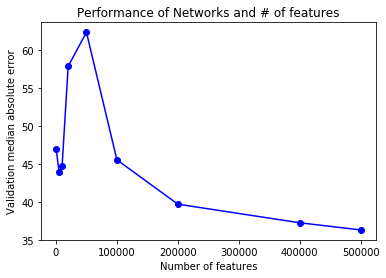

In [10]:
import matplotlib.pyplot as plt
plt.plot(n_features_list, mae_list, marker = "o", c = "b")
plt.title("Performance of Networks and # of features")
plt.xlabel("Number of features")
plt.ylabel("Validation median absolute error")
plt.show()

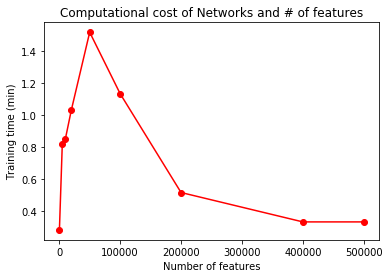

In [12]:
plt.plot(n_features_list, time_list, marker = "o", c = "r")
plt.title("Computational cost of Networks and # of features")
plt.xlabel("Number of features")
plt.ylabel("Training time (min)")
plt.show()

Let's try to extract more features to see if this trend continues for SV regressor. We will tokenize up to 3 words and increase the hashing feature capacity.

In [13]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MaxAbsScaler,FunctionTransformer, Imputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_extraction.text import HashingVectorizer

# First we build two utility functions to parse numeric and text data, 
# and wrap them using FunctionTransformer, so that they can be integrated into a sklearn pipeline:
def text_columns(X_train):
    return X_train.TEXT_FEATURES

def numeric_columns(X_train):
    numeric = ['APPLICANT_PRIOR_CLEARANCE_TO_DATE','DEVICENAME_PRIOR_CLEARANCE_TO_DATE']
    temp = X_train[numeric]
    return temp

get_numeric_data = FunctionTransformer(func = numeric_columns, validate=False) 
get_text_data = FunctionTransformer(func = text_columns,validate=False) 
# Note how we avoid putting any arguments into text_columns and numeric_columns

# We also need to create our regex token pattern to use in HashingVectorizer. 
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'   
#Note this regex will match either a whitespace or a punctuation to tokenize the string vector on these preferences  

# We also need to redefine the default feature selection function for regression to properly place into our pipeline:
def f_regression(X,Y):
    import sklearn
    return sklearn.feature_selection.f_regression(X,Y,center = False) # default is center = True


pipeline510k_SVM1 = Pipeline([
    
    ("union",FeatureUnion( # Note that FeatureUnion() accepts list of tuples, the first half of each tuple is the name of the transformer
        
        transformer_list = [
            
            ("numeric_subpipeline", Pipeline([ # Note we have subpipeline branches inside the main pipeline
                
                ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                ("imputer",Imputer()), # Step2: impute missing values (we don't expect any)
            
            ])), # Branching point of the FeatureUnion
            
            ("text_subpipeline",Pipeline([
            
                ("parser",get_text_data), # Step1: parse the text data 
                ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC,n_features= 8*(2 ** 18),decode_error='ignore',
                                             stop_words = "english",# We will remove English stop words before tokenization
                                             ngram_range = (1,3), # We will tokenize up to 3 words only
                                             non_negative=True, norm=None, binary=True  
                                            )) # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                           
                
            ]))
        ]
    
    )),# Branching point to the main pipeline: at this point all features are numeric
    
    ("scaler",MaxAbsScaler()) # Scale the features
    
])


In [14]:
import datetime
from warnings import filterwarnings
import numpy as np

filterwarnings("ignore")

start = datetime.datetime.now()

X_train_trans_SVM = pipeline510k_SVM1.fit(X_train, y_train).transform(X_train)

end = datetime.datetime.now()
print("Completed processing X_train in: " + str((end-start).seconds/60) + " minutes.")

start = datetime.datetime.now()

X_val_trans_SVM = pipeline510k_SVM1.transform(X_val)

end = datetime.datetime.now()
print("Completed processing X_val in: " + str((end-start).seconds/60) + " minutes.")

Completed processing X_train in: 2.4 minutes.
Completed processing X_val in: 0.4666666666666667 minutes.


In [15]:
print(X_train_trans_SVM.shape)
print(X_val_trans_SVM.shape)
print(type(X_train_trans_SVM))
print(type(X_val_trans_SVM))

(32275, 2097154)
(15899, 2097154)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


In [16]:
from sklearn.metrics import median_absolute_error
import numpy as np
filterwarnings("ignore")

n_features_list = [300,5000,10000,20000,50000,100000,200000,400000,500000,600000,700000,800000,900000,10**6,1500000,2000000]
mae_list = []
time_list = []

for n_features in n_features_list:
    print("Training model using "+ str(n_features)+ " features.")
    
    # Testing feature selection based on training set
    Xt = SelectKBest(f_regression,n_features).fit(X_train_trans_SVM,y_train).transform(X_train_trans_SVM)
    Xv = SelectKBest(f_regression,n_features).fit(X_train_trans_SVM,y_train).transform(X_val_trans_SVM)

    start = datetime.datetime.now()
    
    # Fixed model structure 
    from sklearn.svm import LinearSVR
  
    svr = LinearSVR()
    svr.fit(Xt, np.log(y_train))
    
    preds = svr.predict(Xv)

    # Out-of-box performance using validation set
    mae = median_absolute_error(y_val,np.exp(preds))

    end = datetime.datetime.now()
    
    mae_list.append(mae)
    time_list.append((end-start).seconds/60)

    print("Completed model fit and predictions using "+ str(n_features) + " in: " + str((end-start).seconds/60) + " minutes.")
    print("Median Absolute Error: "+ str(mae) + " features.")
    print("*" * 100)


Training model using 300 features.
Completed model fit and predictions using 300 in: 0.23333333333333334 minutes.
Median Absolute Error: 43.10209678379755 features.
****************************************************************************************************
Training model using 5000 features.
Completed model fit and predictions using 5000 in: 1.0833333333333333 minutes.
Median Absolute Error: 40.698533087388725 features.
****************************************************************************************************
Training model using 10000 features.
Completed model fit and predictions using 10000 in: 1.4166666666666667 minutes.
Median Absolute Error: 50.301215156011494 features.
****************************************************************************************************
Training model using 20000 features.
Completed model fit and predictions using 20000 in: 1.6 minutes.
Median Absolute Error: 65.80833146725905 features.
*******************************************

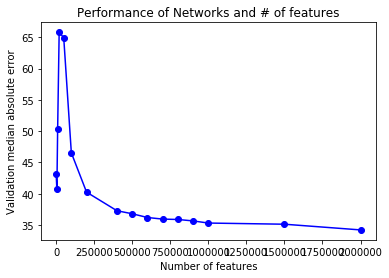

In [17]:
import matplotlib.pyplot as plt
plt.plot(n_features_list, mae_list, marker = "o", c = "b")
plt.title("Performance of Networks and # of features")
plt.xlabel("Number of features")
plt.ylabel("Validation median absolute error")
plt.show()

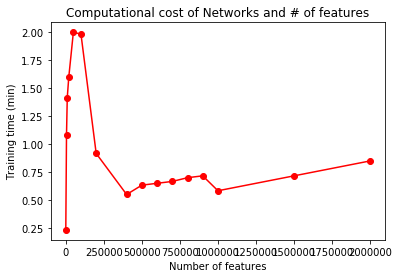

In [18]:
plt.plot(n_features_list, time_list, marker = "o", c = "r")
plt.title("Computational cost of Networks and # of features")
plt.xlabel("Number of features")
plt.ylabel("Training time (min)")
plt.show()

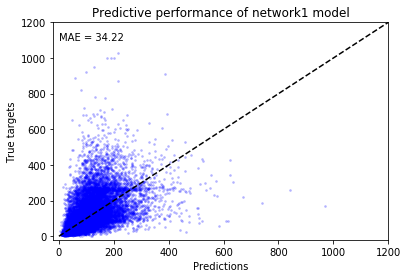

In [22]:
# Bechmark model performance on validation set plotted
def plot_performance(true, preds, model_name):
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import median_absolute_error 
    mae = median_absolute_error(true,np.exp(preds))
    plt.scatter(x = np.exp(preds), y = true, c = 'blue', s = 3, alpha = 0.2)
    plt.xlim(-20,1200)
    plt.ylim(-20,1200)
    plt.plot([0,1200],[0,1200], "--k")
    plt.xlabel("Predictions")
    plt.ylabel("True targets")
    plt.text(0,1100, r"MAE = %.2f"%(mae))
    plt.title("Predictive performance of "+ model_name + " model" )
 
plot_performance(true= y_val, preds= preds, model_name= "network1") 

We still don't see signs of overfitting, at the same time computational costs remain feasible. We will continue extracting features and increase tokenization to 4-grams.

In [23]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MaxAbsScaler,FunctionTransformer, Imputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_extraction.text import HashingVectorizer

# First we build two utility functions to parse numeric and text data, 
# and wrap them using FunctionTransformer, so that they can be integrated into a sklearn pipeline:
def text_columns(X_train):
    return X_train.TEXT_FEATURES

def numeric_columns(X_train):
    numeric = ['APPLICANT_PRIOR_CLEARANCE_TO_DATE','DEVICENAME_PRIOR_CLEARANCE_TO_DATE']
    temp = X_train[numeric]
    return temp

get_numeric_data = FunctionTransformer(func = numeric_columns, validate=False) 
get_text_data = FunctionTransformer(func = text_columns,validate=False) 
# Note how we avoid putting any arguments into text_columns and numeric_columns

# We also need to create our regex token pattern to use in HashingVectorizer. 
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'   
#Note this regex will match either a whitespace or a punctuation to tokenize the string vector on these preferences  

# We also need to redefine the default feature selection function for regression to properly place into our pipeline:
def f_regression(X,Y):
    import sklearn
    return sklearn.feature_selection.f_regression(X,Y,center = False) # default is center = True


pipeline510k_SVM1 = Pipeline([
    
    ("union",FeatureUnion( # Note that FeatureUnion() accepts list of tuples, the first half of each tuple is the name of the transformer
        
        transformer_list = [
            
            ("numeric_subpipeline", Pipeline([ # Note we have subpipeline branches inside the main pipeline
                
                ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                ("imputer",Imputer()), # Step2: impute missing values (we don't expect any)
            
            ])), # Branching point of the FeatureUnion
            
            ("text_subpipeline",Pipeline([
            
                ("parser",get_text_data), # Step1: parse the text data 
                ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC,n_features= 32*(2 ** 18),decode_error='ignore',
                                             stop_words = "english",# We will remove English stop words before tokenization
                                             ngram_range = (1,4), # We will tokenize up to 4 words only
                                             non_negative=True, norm=None, binary=True  
                                            )) # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                           
                
            ]))
        ]
    
    )),# Branching point to the main pipeline: at this point all features are numeric
    
    ("scaler",MaxAbsScaler()) # Scale the features
    
])


In [24]:
import datetime
from warnings import filterwarnings
import numpy as np

filterwarnings("ignore")

start = datetime.datetime.now()

X_train_trans_SVM = pipeline510k_SVM1.fit(X_train, y_train).transform(X_train)

end = datetime.datetime.now()
print("Completed processing X_train in: " + str((end-start).seconds/60) + " minutes.")

start = datetime.datetime.now()

X_val_trans_SVM = pipeline510k_SVM1.transform(X_val)

end = datetime.datetime.now()
print("Completed processing X_val in: " + str((end-start).seconds/60) + " minutes.")

Completed processing X_train in: 3.716666666666667 minutes.
Completed processing X_val in: 0.8333333333333334 minutes.


In [25]:
print(X_train_trans_SVM.shape)
print(X_val_trans_SVM.shape)
print(type(X_train_trans_SVM))
print(type(X_val_trans_SVM))

(32275, 8388610)
(15899, 8388610)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


In [26]:
from sklearn.metrics import median_absolute_error
import numpy as np
filterwarnings("ignore")

n_features_list = [300,5000,10000,20000,50000,100000,200000,400000,
                   500000,600000,700000,800000,900000,10**6,1500000,
                   2000000,2500000,3000000,3500000,4000000,4500000,
                   5000000,5500000,6000000,6500000,7000000,7500000,8000000,8300000]
mae_list = []
time_list = []

for n_features in n_features_list:
    print("Training model using "+ str(n_features)+ " features.")
    
    # Testing feature selection based on training set
    Xt = SelectKBest(f_regression,n_features).fit(X_train_trans_SVM,y_train).transform(X_train_trans_SVM)
    Xv = SelectKBest(f_regression,n_features).fit(X_train_trans_SVM,y_train).transform(X_val_trans_SVM)

    start = datetime.datetime.now()
    
    # Fixed model structure 
    from sklearn.svm import LinearSVR
  
    svr = LinearSVR()
    svr.fit(Xt, np.log(y_train))
    
    preds = svr.predict(Xv)

    # Out-of-box performance using validation set
    mae = median_absolute_error(y_val,np.exp(preds))

    end = datetime.datetime.now()
    
    mae_list.append(mae)
    time_list.append((end-start).seconds/60)

    print("Completed model fit and predictions using "+ str(n_features) + " in: " + str((end-start).seconds/60) + " minutes.")
    print("Median Absolute Error: "+ str(mae) + " features.")
    print("*" * 100)


Training model using 300 features.
Completed model fit and predictions using 300 in: 0.35 minutes.
Median Absolute Error: 36.62756774257225 features.
****************************************************************************************************
Training model using 5000 features.
Completed model fit and predictions using 5000 in: 1.7 minutes.
Median Absolute Error: 43.801205708304565 features.
****************************************************************************************************
Training model using 10000 features.
Completed model fit and predictions using 10000 in: 1.3333333333333333 minutes.
Median Absolute Error: 44.158636579348894 features.
****************************************************************************************************
Training model using 20000 features.
Completed model fit and predictions using 20000 in: 1.5333333333333334 minutes.
Median Absolute Error: 97.38309075770397 features.
**********************************************************

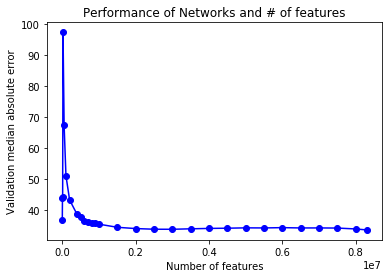

In [27]:
import matplotlib.pyplot as plt
plt.plot(n_features_list, mae_list, marker = "o", c = "b")
plt.title("Performance of Networks and # of features")
plt.xlabel("Number of features")
plt.ylabel("Validation median absolute error")
plt.show()

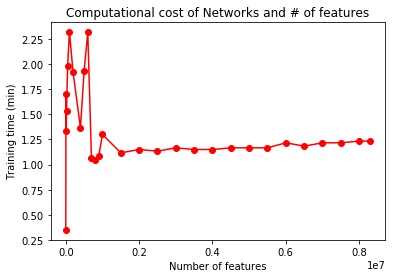

In [28]:
plt.plot(n_features_list, time_list, marker = "o", c = "r")
plt.title("Computational cost of Networks and # of features")
plt.xlabel("Number of features")
plt.ylabel("Training time (min)")
plt.show()

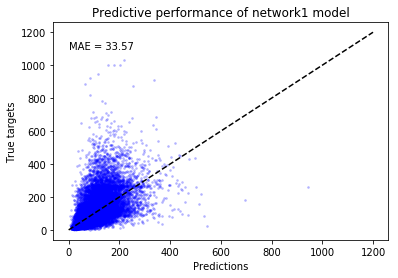

In [30]:
# Bechmark model performance on validation set plotted
def plot_performance(true, preds, model_name):
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import median_absolute_error 
    mae = median_absolute_error(true,np.exp(preds))
    plt.scatter(x = np.exp(preds), y = true, c = 'blue', s = 3, alpha = 0.2)
   # plt.xlim(-20,1200)
   # plt.ylim(-20,1200)
    plt.plot([0,1200],[0,1200], "--k")
    plt.xlabel("Predictions")
    plt.ylabel("True targets")
    plt.text(0,1100, r"MAE = %.2f"%(mae))
    plt.title("Predictive performance of "+ model_name + " model" )
 
plot_performance(true= y_val, preds= preds, model_name= "network1") 

We still don't see signs of overfitting, at the same time computational costs remain feasible. We will continue extracting features and increase tokenization to 5-grams.

In [32]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MaxAbsScaler,FunctionTransformer, Imputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_extraction.text import HashingVectorizer

# First we build two utility functions to parse numeric and text data, 
# and wrap them using FunctionTransformer, so that they can be integrated into a sklearn pipeline:
def text_columns(X_train):
    return X_train.TEXT_FEATURES

def numeric_columns(X_train):
    numeric = ['APPLICANT_PRIOR_CLEARANCE_TO_DATE','DEVICENAME_PRIOR_CLEARANCE_TO_DATE']
    temp = X_train[numeric]
    return temp

get_numeric_data = FunctionTransformer(func = numeric_columns, validate=False) 
get_text_data = FunctionTransformer(func = text_columns,validate=False) 
# Note how we avoid putting any arguments into text_columns and numeric_columns

# We also need to create our regex token pattern to use in HashingVectorizer. 
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'   
#Note this regex will match either a whitespace or a punctuation to tokenize the string vector on these preferences  

# We also need to redefine the default feature selection function for regression to properly place into our pipeline:
def f_regression(X,Y):
    import sklearn
    return sklearn.feature_selection.f_regression(X,Y,center = False) # default is center = True


pipeline510k_SVM1 = Pipeline([
    
    ("union",FeatureUnion( # Note that FeatureUnion() accepts list of tuples, the first half of each tuple is the name of the transformer
        
        transformer_list = [
            
            ("numeric_subpipeline", Pipeline([ # Note we have subpipeline branches inside the main pipeline
                
                ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                ("imputer",Imputer()), # Step2: impute missing values (we don't expect any)
            
            ])), # Branching point of the FeatureUnion
            
            ("text_subpipeline",Pipeline([
            
                ("parser",get_text_data), # Step1: parse the text data 
                ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC,n_features= 64*(2 ** 18),decode_error='ignore',
                                             stop_words = "english",# We will remove English stop words before tokenization
                                             ngram_range = (1,5), # We will tokenize up to 5 words only
                                             non_negative=True, norm=None, binary=True  
                                            )) # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                           
                
            ]))
        ]
    
    )),# Branching point to the main pipeline: at this point all features are numeric
    
    ("scaler",MaxAbsScaler()) # Scale the features
    
])


In [33]:
import datetime
from warnings import filterwarnings
import numpy as np

filterwarnings("ignore")

start = datetime.datetime.now()

X_train_trans_SVM = pipeline510k_SVM1.fit(X_train, y_train).transform(X_train)

end = datetime.datetime.now()
print("Completed processing X_train in: " + str((end-start).seconds/60) + " minutes.")

start = datetime.datetime.now()

X_val_trans_SVM = pipeline510k_SVM1.transform(X_val)

end = datetime.datetime.now()
print("Completed processing X_val in: " + str((end-start).seconds/60) + " minutes.")

Completed processing X_train in: 3.716666666666667 minutes.
Completed processing X_val in: 1.4166666666666667 minutes.


In [34]:
print(X_train_trans_SVM.shape)
print(X_val_trans_SVM.shape)
print(type(X_train_trans_SVM)) 
print(type(X_val_trans_SVM))

(32275, 16777218)
(15899, 16777218)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


In [36]:
from sklearn.metrics import median_absolute_error
import numpy as np
filterwarnings("ignore")

n_features_list = [300,5000,10000,20000,50000,100000,200000,400000,
                   500000,6000000,6500000,7000000,7500000,8000000,8500000,
                  9000000,9500000,10000000,10500000,11000000,11500000,
                  12000000,12500000,13000000,14000000,15000000,16000000]
mae_list = []
time_list = []

for n_features in n_features_list:
    print("Training model using "+ str(n_features)+ " features.")
    
    # Testing feature selection based on training set
    Xt = SelectKBest(f_regression,n_features).fit(X_train_trans_SVM,y_train).transform(X_train_trans_SVM)
    Xv = SelectKBest(f_regression,n_features).fit(X_train_trans_SVM,y_train).transform(X_val_trans_SVM)

    start = datetime.datetime.now()
    
    # Fixed model structure 
    from sklearn.svm import LinearSVR
  
    svr = LinearSVR()
    svr.fit(Xt, np.log(y_train))
    
    preds = svr.predict(Xv)

    # Out-of-box performance using validation set
    mae = median_absolute_error(y_val,np.exp(preds))

    end = datetime.datetime.now()
    
    mae_list.append(mae)
    time_list.append((end-start).seconds/60)

    print("Completed model fit and predictions using "+ str(n_features) + " in: " + str((end-start).seconds/60) + " minutes.")
    print("Median Absolute Error: "+ str(mae) + " features.")
    print("*" * 100)


Training model using 300 features.
Completed model fit and predictions using 300 in: 0.48333333333333334 minutes.
Median Absolute Error: 40.585257859438414 features.
****************************************************************************************************
Training model using 5000 features.
Completed model fit and predictions using 5000 in: 1.35 minutes.
Median Absolute Error: 48.187971478665304 features.
****************************************************************************************************
Training model using 10000 features.
Completed model fit and predictions using 10000 in: 1.5 minutes.
Median Absolute Error: 49.60548406396015 features.
****************************************************************************************************
Training model using 20000 features.
Completed model fit and predictions using 20000 in: 1.7333333333333334 minutes.
Median Absolute Error: 51.26029732701001 features.
*********************************************************

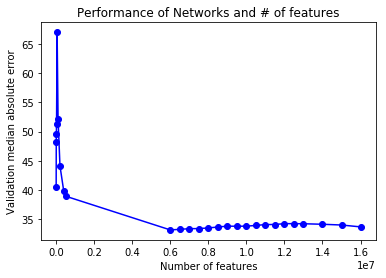

In [37]:
import matplotlib.pyplot as plt
plt.plot(n_features_list, mae_list, marker = "o", c = "b")
plt.title("Performance of Networks and # of features")
plt.xlabel("Number of features")
plt.ylabel("Validation median absolute error")
plt.show()

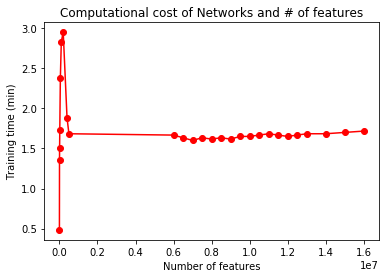

In [38]:
plt.plot(n_features_list, time_list, marker = "o", c = "r")
plt.title("Computational cost of Networks and # of features")
plt.xlabel("Number of features")
plt.ylabel("Training time (min)")
plt.show()

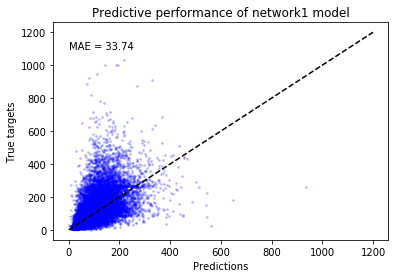

In [39]:
# Bechmark model performance on validation set plotted
def plot_performance(true, preds, model_name):
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import median_absolute_error 
    mae = median_absolute_error(true,np.exp(preds))
    plt.scatter(x = np.exp(preds), y = true, c = 'blue', s = 3, alpha = 0.2)
   # plt.xlim(-20,1200)
   # plt.ylim(-20,1200)
    plt.plot([0,1200],[0,1200], "--k")
    plt.xlabel("Predictions")
    plt.ylabel("True targets")
    plt.text(0,1100, r"MAE = %.2f"%(mae))
    plt.title("Predictive performance of "+ model_name + " model" )
 
plot_performance(true= y_val, preds= preds, model_name= "network1") 

#### Pipeline lockdown

Based on these experiments, we will use 6 million best features selected after tokenization of 5-grams. We will train the pipeline, process the datasets and pursue hyperparameter optimization. 

In [40]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MaxAbsScaler,FunctionTransformer, Imputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_extraction.text import HashingVectorizer

# First we build two utility functions to parse numeric and text data, 
# and wrap them using FunctionTransformer, so that they can be integrated into a sklearn pipeline:
def text_columns(X_train):
    return X_train.TEXT_FEATURES

def numeric_columns(X_train):
    numeric = ['APPLICANT_PRIOR_CLEARANCE_TO_DATE','DEVICENAME_PRIOR_CLEARANCE_TO_DATE']
    temp = X_train[numeric]
    return temp

get_numeric_data = FunctionTransformer(func = numeric_columns, validate=False) 
get_text_data = FunctionTransformer(func = text_columns,validate=False) 
# Note how we avoid putting any arguments into text_columns and numeric_columns

# We also need to create our regex token pattern to use in HashingVectorizer. 
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'   
#Note this regex will match either a whitespace or a punctuation to tokenize the string vector on these preferences  

# We also need to redefine the default feature selection function for regression to properly place into our pipeline:
def f_regression(X,Y):
    import sklearn
    return sklearn.feature_selection.f_regression(X,Y,center = False) # default is center = True


pipeline510k_SVM1 = Pipeline([
    
    ("union",FeatureUnion( # Note that FeatureUnion() accepts list of tuples, the first half of each tuple is the name of the transformer
        
        transformer_list = [
            
            ("numeric_subpipeline", Pipeline([ # Note we have subpipeline branches inside the main pipeline
                
                ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                ("imputer",Imputer()), # Step2: impute missing values (we don't expect any)
            
            ])), # Branching point of the FeatureUnion
            
            ("text_subpipeline",Pipeline([
            
                ("parser",get_text_data), # Step1: parse the text data 
                ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC,n_features= 64*(2 ** 18),decode_error='ignore',
                                             stop_words = "english",# We will remove English stop words before tokenization
                                             ngram_range = (1,5), # We will tokenize up to 5 words only
                                             non_negative=True, norm=None, binary=True  
                                            )) # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                           
                
            ]))
        ]
    
    )),# Branching point to the main pipeline: at this point all features are numeric
    
    ("scaler",MaxAbsScaler()), # Scale the features
    ("dim_red", SelectKBest(f_regression,6000000))
])


In [ ]:
import datetime
from warnings import filterwarnings
import numpy as np

filterwarnings("ignore")

start = datetime.datetime.now()

X_train_trans_SVM = pipeline510k_SVM1.fit(X_train, y_train).transform(X_train)

end = datetime.datetime.now()
print("Completed processing X_train in: " + str((end-start).seconds/60) + " minutes.")

start = datetime.datetime.now()

X_val_trans_SVM = pipeline510k_SVM1.transform(X_val)

end = datetime.datetime.now()
print("Completed processing X_val in: " + str((end-start).seconds/60) + " minutes.")

In [ ]:
print(X_train_trans_SVM.shape)
print(X_val_trans_SVM.shape)
print(type(X_train_trans_SVM)) 
print(type(X_val_trans_SVM))

#### Bayesian Optimization

In [ ]:
# We start by defining the score we want to be maximized using Bayesian Optimization
# Note that the parameters we will optimize are called as generic arguments

seed = 112 # Random seed

def svr_score(C):
    from sklearn.metrics import median_absolute_error
    import numpy as np
    
    svr = LinearSVR(C = C)
    svr.fit(X_train_trans_SVM, np.log(y_train))
    
    preds = svr.predict(Xv)

    # Out-of-box performance using validation set
    mae = median_absolute_error(y_val,np.exp(preds))
    
    # return the - mae to be maximized
    return - mae 

In [ ]:
import warnings
import lightgbm as lgb
warnings.filterwarnings('ignore')

from bayes_opt import BayesianOptimization

# alpha is a parameter for the gaussian process
# Note that this is itself a hyperparemter that can be optimized.
gp_params = {"alpha": 1e-10}

# We create the BayesianOptimization objects using the functions that utilize
# the respective classifiers and return cross-validated scores to be optimized.

seed = 112 # Random seed

# We create the bayes_opt object and pass the function to be maximized
# together with the parameters names and their bounds.
# Note the syntax of bayes_opt package: bounds of hyperparameters are passed as two-tuples

hyperparameter_space = {
    'C':(0.01,100)
}

svrBO = BayesianOptimization(f = svr_score, 
                             pbounds =  hyperparameter_space,
                             random_state = seed,
                             verbose = 10)

# Finally we call .maximize method of the optimizer with the appropriate arguments
# kappa is a measure of 'aggressiveness' of the bayesian optimization process
# The algorithm will randomly choose 3 points to establish a 'prior', then will perform 
# interations to maximize the value of estimator function
svrBO.maximize(init_points=10,n_iter=10,acq='ucb', kappa= 3, **gp_params)